# Deep Q-Learning For Cartpole 

In [1]:
# Import Packages
import time 

import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1045638060376261632
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15051309432244085766
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num CPUs Available:  1
Num GPUs Available:  0


In [4]:
# create the envirnment
env = gym.make("CartPole-v1")

In [5]:
# Get the observation space and actionn space
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

print('The observation space is: ', observation_space)
print('The action space: ', action_space)

The observation space is:  4
The action space:  2


In [6]:
# Test environment
state = env.reset()
state_next, reward, terminal, info = env.step(env.action_space.sample())
print('Next_state: ', state_next)
print('Rewards:',   reward)

Next_state:  [ 0.01140017 -0.21060692  0.04348403  0.2825726 ]
Rewards: 1.0


In [7]:
# Parameters
GAMMA = 0.95                       # discount factor
LEARNING_RATE = 0.001              # learning rate for optimiser

MEMORY_SIZE = 20000                # memeory size of the deque
BATCH_SIZE = 32                   # Batch size for training 

EXPLORATION_MAX = 1.0              
EXPLORATION_MIN = 0.1
EXPLORATION_DECAY = 0.995

exploration_rate = EXPLORATION_MAX

In [8]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(24, input_shape=(observation_space,), activation="relu"))
model.add(tf.keras.layers.Dense(24, activation="relu"))
model.add(tf.keras.layers.Dense(action_space, activation="linear"))
model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


In [8]:
def Create_Q_Network(useDuel = True):
    
    # Create base model
    input_layer = tf.keras.Input(shape = (observation_space, ))
    dense1 = tf.keras.layers.Dense(24, activation='relu')(input_layer)
    dense2 = tf.keras.layers.Dense(24, activation='relu')(dense1)
    
#     # Create advantage stream
#     fc1 = tf.keras.layers.Dense(24)(dense2)
#     advantage = tf.keras.layers.Dense(action_space)(fc1)
#     advantage = tf.subtract(advantage, tf.reduce_mean(advantage, axis=-1, keepdims=True))

#     # create value stream
#     fc2 = tf.keras.layers.Dense(24)(dense2)
#     value = tf.keras.layers.Dense(1)(fc2)

#     # Output 
#     output = tf.add(value, advantage)

#     # Create advantage stream
#     fc1 = tf.keras.layers.Dense(24)(dense2)
#     advantage = tf.keras.layers.Dense(action_space)(fc1)
#     advantage_normalised = tf.keras.layers.Lambda(lambda advt: advt - tf.reduce_mean(advt, axis=-1, keepdims=True))(advantage)

#     # create value stream
#     fc2 = tf.keras.layers.Dense(24)(dense2)
#     value = tf.keras.layers.Dense(1)(fc2)
#     value_expanded = tf.keras.layers.Lambda(lambda value: tf.tile(value, [1, action_space]))(value)

#     # Output 
#     output = tf.keras.layers.Add()([value_expanded, advantage_normalised])

    output = tf.keras.layers.Dense(action_space, activation="linear")(dense2)

    # Compile model
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=LEARNING_RATE))
    
    return model

In [9]:
# Create the DQN and Target DQN
DQNetwork = Create_Q_Network()
TargetDQNewtork = Create_Q_Network()

DQNetwork.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 24)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


In [10]:
def update_model():
    TargetDQNewtork.set_weights(DQNetwork.get_weights())
update_model()

In [11]:
sample_state = np.random.rand(1,4)
print(DQNetwork(sample_state))
print(TargetDQNewtork(sample_state))

tf.Tensor([[-0.27021024  0.15879287]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.27021024  0.15879287]], shape=(1, 2), dtype=float32)


In [11]:
# Append experience to memory
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

In [12]:
# Function to retuen an action based on the state
def act(state):
    
    # Return random action if epsilon 
    if np.random.rand() < exploration_rate:
        return random.randrange(action_space)
    
    # Else return the action predicted by model
    q_values = DQNetwork.predict(state)
    
    return np.argmax(q_values[0])

In [13]:
# define training strategy via per sample or per batch
def train_batch(batch):
    ''' 
    function to train via each batch
    '''
    # Initialise list of target Q and states
    target_Q = []
    state_train = []

    # Extract each parameter from batch
    for state, action, reward, state_next, done in batch:

        # add states to list
        state_train.append(state[0])

        # Add the target Q to list
        if done:
            Q_values = DQNetwork.predict(state)
            Q_values[0][action] = reward
            target_Q.append(Q_values[0])
        else:
            Q_values = DQNetwork.predict(state)
            best_action = np.argmax(Q_values)
            Q_values[0][action] = reward + GAMMA * TargetDQNewtork.predict(state_next)[0][best_action]
            target_Q.append(Q_values[0])

    # turn states and target Q in numpy arrays
    state_train = np.array(state_train)
    target_Q = np.array(target_Q)
    
    # Fit a a batch of results
    history = DQNetwork.fit(state_train, target_Q, verbose=0)
    
    return history.history['loss'][0]

In [14]:
def model_fit(batch):

    # Extract each parameter from batch
    state_batch = np.zeros((BATCH_SIZE, observation_space))
    action_batch = np.zeros(BATCH_SIZE, dtype = int)
    reward_batch = np.zeros(BATCH_SIZE)
    state_next_batch = np.zeros((BATCH_SIZE, observation_space))
    done_batch = np.zeros(BATCH_SIZE)
    for i in range(0,len(batch)):
        state_batch[i] = batch[i][0]
        action_batch[i] = batch[i][1]
        reward_batch[i] = batch[i][2]
        state_next_batch[i] = batch[i][3]
        done_batch[i] = batch[i][4]

    # Get predicted Q values
    target_Q_batch = DQNetwork.predict(state_batch)
    Q_state_old = np.array(target_Q_batch)
    Q_next_state = DQNetwork.predict(state_next_batch)
    Target_Q_next_state = TargetDQNewtork.predict(state_next_batch)
    
    # For debugging
    best_acts = []
    # Calculate target Q
    for i in range(0,len(batch)):
        if done_batch[i]:
            target_Q_batch[i][action_batch[i]] = reward_batch[i]
        else:
            best_action = np.argmax(Q_next_state[i])
            best_acts.append(best_action)
            target_Q_batch[i][action_batch[i]] = reward_batch[i] + GAMMA * Target_Q_next_state[i][best_action]


    # Update the sum tree priority values based on new absolute errors
    indices = np.arange(BATCH_SIZE, dtype=np.int32)

    history = DQNetwork.fit(state_batch, target_Q_batch, batch_size=BATCH_SIZE,  verbose = 0)
    
    return history.history['loss'][0], sum(target_Q_batch[indices, np.array(action_batch)]),  best_acts # For debugging

In [15]:
### Learning function ###

def experience_replay():
    
    global exploration_rate
    
    # Start training only if memeory size has reached beyond batch size
    if len(memory) < BATCH_SIZE:
        return 0,0,0
    
    # Take a sample batch from the memory
    batch = random.sample(memory, BATCH_SIZE)
    
    # train procedure
    loss, target_test, best_action_test = model_fit(batch)
        
    # Reduce the exploration 
    exploration_rate *= EXPLORATION_DECAY
    exploration_rate = max(EXPLORATION_MIN, exploration_rate)
    
    return loss, target_test, best_action_test

In [16]:
def test(n_episodes, model=None, with_limit=True, store = False):
    ''' 
    function to test the result of the model for n_episodes and return average
    rewards
    '''
    # store average rewards
    avg_rewards = 0

    for i in range(1, n_episodes+1):

        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        
        done = False 
        total_rewards = 0
        step = 0 
        
        
        # until done 
        while not done:
            
            # take an action in the max q_table
            if model:
                action = np.argmax(model.predict(state)[0])
            else:
                action = env.action_space.sample()
                
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, observation_space])
            
            if store:
                memory.append((state, action, reward, next_state, done))
                
            state = next_state
            
            # acculmulate rewards
            total_rewards += reward
            step += 1
            
            
            # End the epsiode if step > 200 
            if with_limit:
                if step > 200:
                    done = True
            
        avg_rewards = avg_rewards + 1/(i) * (total_rewards - avg_rewards)
          
    return avg_rewards

In [18]:
memory = deque(maxlen=MEMORY_SIZE)
test(5, model=None, with_limit=True, store = True)

# Sample from batch
batch = random.sample(memory, BATCH_SIZE)
loss,x,y= model_fit(batch)
print(loss)
print(train_batch(batch))


0.6499465107917786


NameError: name 'train_batch' is not defined

In [19]:
TargetDQNewtork.predict(sample_state)[0]

array([0.13517563, 0.14672862], dtype=float32)

In [17]:
### Learning in the environment ###

# Initialise the run
memory = deque(maxlen=MEMORY_SIZE)
run = 0
N = 200
total_steps = 0

# Initialise score capture
run_list = []
avg_score_list = []
step_list = []
loss_list = []


# For debugging
target_tests=[]
best_action_tests=[]

# Run for N episodes
for i in range(0,N):
    
    # update run number
    run += 1
    
    # Initialise environment 
    state = env.reset()
    terminal = False
    state = np.reshape(state, [1, observation_space])
    step = 0
    
    # Run each episode
    while not terminal:
        
        # update the step number 
        step += 1
        total_steps += 1
        
        # choose an action
        action = act(state)
        
        # Take a step
        state_next, reward, terminal, info = env.step(action)
        
        # Reward negatively if episode ended
        reward = reward if not terminal else -reward
        
        # reshape state_next to format of model.predict()
        state_next = np.reshape(state_next, [1, observation_space])
        
        # Add experience to memory
        remember(state, action, reward, state_next, terminal)
        
        # set next state
        state = state_next
        
        # End the epsiode if step > 200 
        if step > 200:
            terminal = True
        
        # Print message at the end of every episode 
        if terminal:
            avg_rewards = test(5, DQNetwork,  with_limit=True)
            
            # append history of score
            run_list.append(run)
            step_list.append(step)
            avg_score_list.append(avg_rewards)
            
            print("Run: " + str(run) + ", exploration: " + str(exploration_rate) + ", average score: " + str(avg_rewards))
        
        if total_steps % 1000 ==0:
            update_model()
            print("Target Model Updated!")
        
        # Train for a batch of batch size 
        loss, x, y = experience_replay()
        loss_list.append(loss)
        target_tests.append(x)
        best_action_tests.append(y)
    
print('Done Training!')        

Run: 1, exploration: 1.0, average score: 9.2
Run: 2, exploration: 0.985074875, average score: 9.4
Run: 3, exploration: 0.9137248860125932, average score: 12.2
Run: 4, exploration: 0.810157377815473, average score: 9.8
Run: 5, exploration: 0.7744209942832988, average score: 9.2
Run: 6, exploration: 0.7183288830986236, average score: 10.2
Run: 7, exploration: 0.6797938283326578, average score: 13.8
Run: 8, exploration: 0.6211445383053219, average score: 16.0
Run: 9, exploration: 0.5761543988830038, average score: 16.4
Run: 10, exploration: 0.531750826943791, average score: 16.2
Run: 11, exploration: 0.4982051627146237, average score: 19.8
Run: 12, exploration: 0.446186062443672, average score: 15.8
Run: 13, exploration: 0.40565285250151817, average score: 16.6
Run: 14, exploration: 0.37251769488706843, average score: 18.4
Run: 15, exploration: 0.33195389135223546, average score: 21.2
Run: 16, exploration: 0.3017979588795719, average score: 15.8
Run: 17, exploration: 0.2730095965279488, a

Run: 162, exploration: 0.1, average score: 167.8
Run: 163, exploration: 0.1, average score: 151.0
Run: 164, exploration: 0.1, average score: 172.4
Target Model Updated!
Run: 165, exploration: 0.1, average score: 172.4
Run: 166, exploration: 0.1, average score: 184.4
Run: 167, exploration: 0.1, average score: 166.6
Run: 168, exploration: 0.1, average score: 179.2
Run: 169, exploration: 0.1, average score: 183.8
Run: 170, exploration: 0.1, average score: 177.4
Target Model Updated!
Run: 171, exploration: 0.1, average score: 168.2
Run: 172, exploration: 0.1, average score: 184.0
Run: 173, exploration: 0.1, average score: 174.2
Run: 174, exploration: 0.1, average score: 193.8
Run: 175, exploration: 0.1, average score: 185.8
Run: 176, exploration: 0.1, average score: 182.2
Target Model Updated!
Run: 177, exploration: 0.1, average score: 169.8
Run: 178, exploration: 0.1, average score: 179.2
Run: 179, exploration: 0.1, average score: 176.8
Run: 180, exploration: 0.1, average score: 186.8
Run

KeyboardInterrupt: 

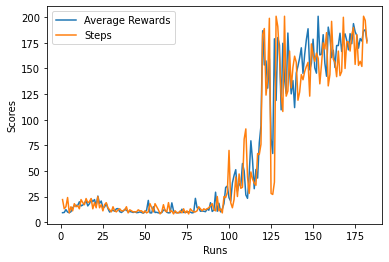

In [18]:
# plot result
plt.plot(run_list, avg_score_list, run_list, step_list)
plt.ylabel('Scores')
plt.xlabel('Runs')
plt.legend(['Average Rewards', 'Steps'])
plt.show()

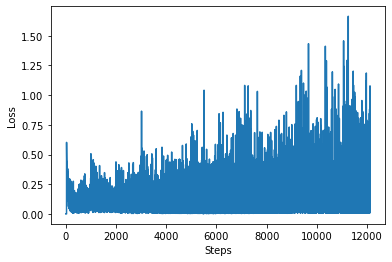

In [19]:
# plot loss
plt.plot(loss_list)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.show()

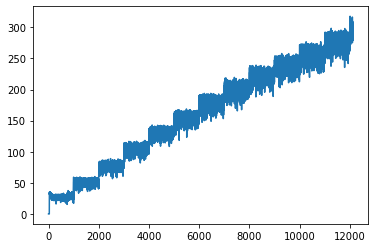

In [20]:
plt.plot(target_tests)  # For debugging

In [23]:
# run test
n_episodes = 50
avg_rewards = test(n_episodes, DQNetwork, with_limit = False, memory=None)
print("After " + str(n_episodes) + " episodes, the average score is " + str(avg_rewards))

After 50 episodes, the average score is 309.0200000000001


In [28]:
# Initialise environment 
state = env.reset()
state = np.reshape(state, [1, observation_space])
done = False 
total_reward = 0
steps = 0

# Until done 
while not done:

    # render the current environment 
    env.render()

    # take an action using model
    action = np.argmax(DQNetwork.predict(state))
    state, reward, done, info = env.step(action)
    state = np.reshape(state, [1, observation_space])

    total_reward += reward
    steps += 1

    # pause for visualisation
    time.sleep(0.01)

env.close()
print ("Score: {}, Steps: {}".format(total_reward, steps))

Score: 152.0, Steps: 152
